### Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import kornia
from functools import partial
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Definitions

In [2]:
# data
BATCH_SIZE = 256

# runs
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 100

# augmentation
IMAGE_SIZE = 48
PATCH_SIZE = 6  # Size of the patches to be extract from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

# encoder/decoder
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 3
DEC_NUM_HEADS = 4
DEC_LAYERS = 1

### Load Dataset

#### a) Data Augmentation

In [3]:
import torchvision.transforms as transforms

train_tf = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

#### b) Load dataset

##### CIFAR10

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

trainset = CIFAR10(root='./data', train=True, download=True, transform=train_tf)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = CIFAR10(root='./data', train=False, download=True, transform=test_tf)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(trainset)}")
print(f"Testing samples: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Testing samples: 10000


##### CelebA

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import CelebA

trainset = CelebA(root='./data', split='train', download=True, transform=train_tf)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = CelebA(root='./data', split='test', download=True, transform=test_tf)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(trainset)}")
print(f"Testing samples: {len(testset)}")

### Create Patches
Create patches from input images

In [5]:
class Patches():
    def __init__(self, patch_size=PATCH_SIZE):
        super().__init__()
        self.patch_size = patch_size
        
    def __call__(self, images):
        patches = kornia.contrib.extract_tensor_patches(
            input=images,
            window_size=(self.patch_size, self.patch_size),
            stride=(self.patch_size, self.patch_size),
        )
        
        # (batch, num_patches, channels, patch_height, patch_width)
        return patches
        
    def show_patched_image(self, images, patches):
        """This is a utility function which accepts a batch of images and its corresponding patches and help visualize one image and its patches side by side."""
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(images[idx].permute(1, 2, 0).numpy())
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = patch.permute(1, 2, 0).numpy()
            plt.imshow(patch_img)
            plt.axis("off")
        plt.show()
        
        # Return the index chosen to validate it outside the method.
        return idx
    
    def reconstruct_from_patch(self, patch):
        """Takes the patches from a single image and reconstructs it back into the image"""
        num_patches = patch.shape[0]
        nrows = int(np.sqrt(num_patches))
        # View as (batch, patch_height, patch_width, channels)
        patch = patch.permute(0, 2, 3, 1)
        rows = patch.split(nrows, dim=0)
        rows = [torch.cat(torch.unbind(x), dim=1) for x in rows]
        reconstructed = torch.cat(rows, dim=0)
        return reconstructed

Index selected: 186.


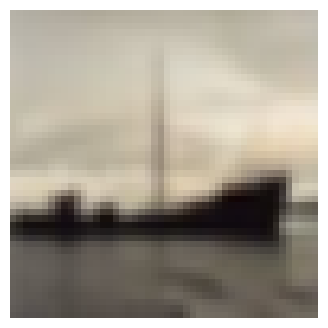

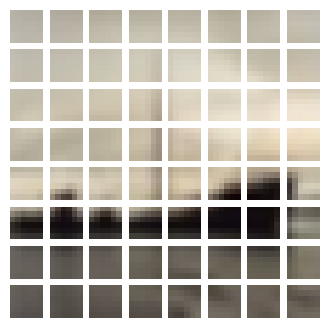

In [6]:
# Get a batch of images.
images, labels = next(iter(trainloader))

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=images)

# Pass the images and its patches to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=images, patches=patches)

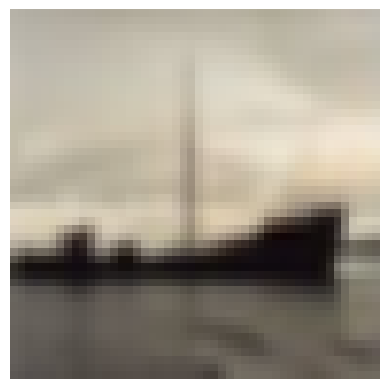

In [7]:
# Get the same image and try reconstructing the patches into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

### Patch Encoder
This layer deals with encoding the patches and adding the positional embedding

In [8]:
class PatchEncoder(nn.Module):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        n_channels=3,
    ):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.num_mask = int(self.mask_proportion * self.num_patches)
        
        # Create the projection layer for the patches
        in_features = n_channels * patch_size * patch_size
        self.projection = nn.Linear(in_features=in_features, out_features=self.projection_dim)
        
        # Create the positional embedding layer
        self.positional_embedding = nn.Embedding(num_embeddings=self.num_patches, embedding_dim=self.projection_dim)
    
    def __call__(self, patches):
        # View patches as (batch, num_patches, patch_area)
        patches = patches.view(*patches.shape[:2], -1)

        # Get the positional embeddings
        batch_size = patches.shape[0]
        positions = torch.arange(start=0, end=self.num_patches, step=1)
        pos_embeddings = self.positional_embedding(positions[None, :].to(device))
        pos_embeddings = torch.tile(pos_embeddings, (batch_size, 1, 1))

        # Embed the patches
        patch_embeddings = (self.projection(patches.to(device)) + pos_embeddings)
        
        batch_size = patches.shape[0]
        mask_indices, unmask_indices = self.get_random_indices(batch_size)

        # The encoder input is the unmasked patch embeddings. Here we gather all the patches that should be unmasked.
        unmasked_embeddings = self.gather_torch(patch_embeddings, unmask_indices.unsqueeze(2))

        # Get the unmasked and masked position embeddings. We will need them for the decoder.
        unmasked_positions = self.gather_torch(pos_embeddings, unmask_indices.unsqueeze(2))
        masked_positions = self.gather_torch(pos_embeddings, mask_indices.unsqueeze(2))

        # Repeat the mask token number of mask times. Mask tokens replace the masks of the image.
        mask_token = torch.normal(size=(1, self.patch_size * self.patch_size * 3), mean=0.0, std=1.0)
        mask_tokens = mask_token.repeat((self.num_mask, 1))
        mask_tokens = mask_tokens.unsqueeze(0).repeat((batch_size, 1, 1))

        masked_embeddings = self.projection(mask_tokens.to(device)) + masked_positions

        return (
            unmasked_embeddings,    # input to the encoder
            masked_embeddings,      # first part of input to the decoder
            unmasked_positions,     # added to the encoder outputs
            mask_indices,           # the indices that were masked
            unmask_indices,         # the indices that were unmasked
        )
    
    def get_random_indices(self, batch_size):
        """Create random indices from a uniform distribution and then split it into mask and unmask indices"""
        rand_indices = torch.argsort(
           torch.rand(size=(batch_size, self.num_patches)), dim=-1
        )
        mask_indices = rand_indices[:, :self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask:]
        return mask_indices, unmask_indices
    
    def show_masked_image(self, patches, unmask_indices):
        # Choose a random patch and its corresponding unmask index
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch
        new_patch = np.zeros_like(patch)

        # Iterate over the new_patch and plug the unmasked patches
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

    def gather_torch(self, params, indices, batch_dim=1):
        """A PyTorch porting of tensorflow.gather_nd by Kulbear https://gist.github.com/Kulbear/b421c32fb64deddfd0403340db4eeeaa
        
        Args:
            params: a tensor of dimension [b1, ..., bn, g1, ..., gm, c].
            indices: a tensor of dimension [b1, ..., bn, x, m]
            batch_dim: indicate how many batch dimension you have, in the above example, batch_dim = n.
        Returns:
            gathered: a tensor of dimension [b1, ..., bn, x, c].
        """
        batch_dims = params.size()[:batch_dim]          # [b1, ..., bn]
        batch_size = np.cumprod(list(batch_dims))[-1]   # b1 * ... * bn
        c_dim = params.size()[-1]                       # c
        grid_dims = params.size()[batch_dim:-1]         # [g1, ..., gm]
        n_indices = indices.size(-2)                    # x
        n_pos = indices.size(-1)                        # m

        # Reshape leading batch dims to a single batch dim
        params = params.reshape(batch_size, *grid_dims, c_dim)
        indices = indices.reshape(batch_size, n_indices, n_pos)

        # Build gather indices
        # Gather for each of the data point in this "batch"
        batch_enumeration = torch.arange(batch_size).unsqueeze(1)
        gather_dims = [indices[:, :, i] for i in range(len(grid_dims))]
        gather_dims.insert(0, batch_enumeration)
        gathered = params[gather_dims]

        # Reshape back to the shape with leading batch dims
        gathered = gathered.reshape(*batch_dims, n_indices, c_dim)
        return gathered

In [9]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()
patch_encoder.to(device)

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)

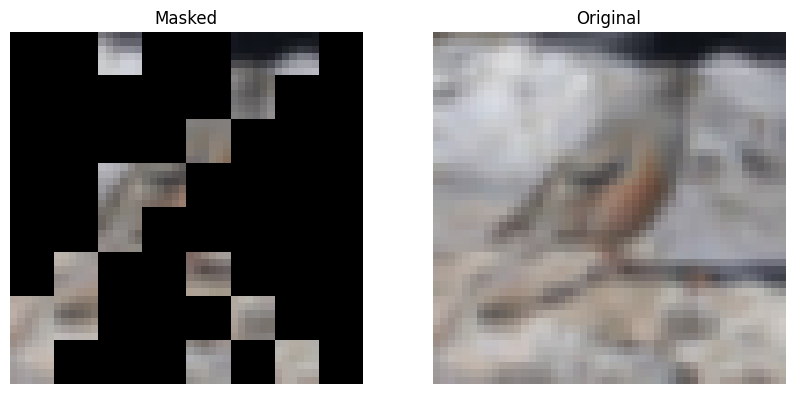

In [10]:
# Show a masked patch image.
new_patch, random_index = patch_encoder.show_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(torch.from_numpy(new_patch))
plt.imshow(img)
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = images[random_index].permute(1, 2, 0)
plt.imshow(img)
plt.axis("off")
plt.title("Original")
plt.show()

### MaskedAutoEncoder Model

#### Encoder

In [11]:
import timm.models.vision_transformer

class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm
            
    def __call__(self, input):
        # Layer normalization
        input = self.norm(input)
        
        # Transformer blocks
        for blk in self.blocks:
            input = blk(input)
        
        # Normalize
        input = self.norm(input)
        
        return input

#### Decoder

In [12]:
from timm.models.vision_transformer import Block

class MAEDecoder(nn.Module):
    """Decoder for the Masked Autoencoder model [0].

    Decodes encoded patches and predicts pixel values for every patch.
    Code inspired by [1].

    - [0]: Masked Autoencoder, 2021, https://arxiv.org/abs/2111.06377
    - [1]: https://github.com/facebookresearch/mae

    Attributes:
        num_patches:
            Number of patches.
        patch_size:
            Patch size.
        in_chans:
            Number of image input channels.
        embed_dim:
            Embedding dimension of the encoder.
        decoder_embed_dim:
            Embedding dimension of the decoder.
        decoder_depth:
            Depth of transformer.
        decoder_num_heads:
            Number of attention heads.
        mlp_ratio:
            Ratio of mlp hidden dim to embedding dim.
        proj_drop_rate:
            Percentage of elements set to zero after the MLP in the transformer.
        attn_drop_rate:
            Percentage of elements set to zero after the attention head.
        norm_layer:
            Normalization layer.
        mask_token:
            The mask token.

    """

    def __init__(
        self,
        num_patches,
        patch_size,
        in_chans=3,
        embed_dim=1024,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
        proj_drop_rate=0.0,
        attn_drop_rate=0.0,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()

        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, num_patches, decoder_embed_dim), requires_grad=False
        )  # fixed sin-cos embedding

        self.decoder_blocks = nn.Sequential(
            *[
                Block(
                    decoder_embed_dim,
                    decoder_num_heads,
                    mlp_ratio,
                    qkv_bias=True,
                    norm_layer=norm_layer,
                    proj_drop=proj_drop_rate,
                    attn_drop=attn_drop_rate,
                )
                for i in range(decoder_depth)
            ]
        )

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(
            decoder_embed_dim, patch_size**2 * in_chans, bias=True
        )  # decoder to patch

    def forward(self, input):
        """Returns predicted pixel values from encoded tokens.

        Args:
            input:
                Tensor with shape (batch_size, seq_length, embed_input_dim).

        Returns:
            Tensor with shape (batch_size, seq_length, out_dim).

        """
        out = self.embed(input)
        out = self.decode(out)
        return self.predict(out)

    def embed(self, input):
        """Embeds encoded input tokens into decoder token dimension.

        This is a single linear layer that changes the token dimension from
        embed_input_dim to hidden_dim.

        Args:
            input:
                Tensor with shape (batch_size, seq_length, embed_input_dim)
                containing the encoded tokens.

        Returns:
            Tensor with shape (batch_size, seq_length, hidden_dim) containing
            the embedded tokens.

        """
        out = self.decoder_embed(input)
        return out

    def decode(self, input):
        """Forward pass through the decoder transformer.

        Args:
            input:
                Tensor with shape (batch_size, seq_length, hidden_dim) containing
                the encoded tokens.

        Returns:
            Tensor with shape (batch_size, seq_length, hidden_dim) containing
            the decoded tokens.

        """
        output = self.decoder_blocks(input)
        output = self.decoder_norm(output)
        return output

    def predict(self, input):
        """Predics pixel values from decoded tokens.

        Args:
            input:
                Tensor with shape (batch_size, seq_length, hidden_dim) containing
                the decoded tokens.

        Returns:
            Tensor with shape (batch_size, seq_length, out_dim) containing
            predictions for each token.

        """
        out = self.decoder_pred(input)
        return out

In [13]:
encoder = VisionTransformer(
    patch_size=PATCH_SIZE,
    embed_dim=ENC_PROJECTION_DIM,
    depth=ENC_LAYERS,
    num_heads=ENC_NUM_HEADS,
    mlp_ratio=4,
    qkv_bias=True,
    norm_layer=partial(nn.LayerNorm, eps=LAYER_NORM_EPS),
)
encoder.to(device)

decoder = MAEDecoder(
    num_patches=NUM_PATCHES,
    patch_size=PATCH_SIZE,
    embed_dim=ENC_PROJECTION_DIM,
    decoder_embed_dim=DEC_PROJECTION_DIM,
    decoder_depth=DEC_LAYERS,
    decoder_num_heads=DEC_NUM_HEADS,
    mlp_ratio=4.0,
    proj_drop_rate=0.1,
    attn_drop_rate=0.1,
)
decoder.to(device)

MAEDecoder(
  (decoder_embed): Linear(in_features=128, out_features=64, bias=True)
  (decoder_blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.1, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop2): Dropout(p=0.1, inplace=False)
      )
      (ls2): Identity()
      

#### MaskedAutoEncoder Model

In [14]:
class MaskedAutoEncoder(nn.Module):
    def __init__(
        self,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
    ):
        super().__init__()
        self.mask_ratio = MASK_PROPORTION
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def forward_encoder(self, unmasked_embeddings):
        return self.encoder(unmasked_embeddings)

    def forward_decoder(self, decoder_inputs):
        # Decoder forward pass
        x_decode = self.decoder.embed(decoder_inputs)
        x_decoded = self.decoder.decode(x_decode)
        # Predict pixel values
        x_pred = self.decoder.predict(x_decoded)
        return x_pred

    def forward(self, images):
        # Patch the images
        patches = self.patch_layer(images)
        
        # Reshape patches as (batch_size, num_patches, channels*patch_size**2)
        patches = patches.reshape(*patches.size()[:2], -1)
        
        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmasked patches to the encoder
        encoder_outputs = self.forward_encoder(unmasked_embeddings)
        
        # Create the decoder inputs
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = torch.concat((encoder_outputs, masked_embeddings), dim=1)
        
        # Decode the inputs
        decoder_outputs = self.forward_decoder(decoder_inputs)
        
        predictions = self.patch_encoder.gather_torch(decoder_outputs, mask_indices.unsqueeze(2))
        targets = self.patch_encoder.gather_torch(patches, mask_indices.unsqueeze(2))

        return predictions, targets

In [15]:
mae_model = MaskedAutoEncoder(
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)
mae_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(mae_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [17]:
# Test run
predictions, targets = mae_model(images)

torch.Size([256, 48, 108])
torch.Size([256, 48, 108])


### Training

In [ ]:
# Monitor the model's progress
class TrainMonitor():
    def __init__(self, model, testloader, epoch_interval=5):
        self.epoch_interval = epoch_interval
        self.model = model
        self.test_images, _ = next(iter(testloader))

    def output_progress(self, epoch):
        if epoch % self.epoch_interval != 0:
            return
        
        test_patches = self.model.patch_layer(self.test_images)
        (
            test_unmasked_embeddings,
            test_masked_embeddings,
            test_unmasked_positions,
            test_mask_indices,
            test_unmask_indices,
        ) = self.model.patch_encoder(test_patches)
        
        test_encoder_outputs = self.model.forward_encoder(test_unmasked_embeddings)
        test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
        
        test_decoder_inputs = torch.concat((test_encoder_outputs, test_masked_embeddings), dim=1)
        
        # (batch_size, image_h, image_w, channels)
        test_decoder_outputs = self.model.forward_decoder(test_decoder_inputs)

        # Show a masked patch image.
        test_masked_patch, idx = self.model.patch_encoder.show_masked_image(
            test_patches, test_unmask_indices
        )
        print(test_masked_patch.shape)
        print(f"\nIdx chosen: {idx}")
        original_image = self.test_images[idx]
        masked_image = self.model.patch_layer.reconstruct_from_patch(
            torch.from_numpy(test_masked_patch)
        )
        
        # (image_h, image_w, channels)
        reconstructed_image = test_decoder_outputs[idx]
        print(test_decoder_outputs.shape)
        print(reconstructed_image.shape)

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        ax[0].imshow(original_image.permute(1, 2, 0))
        ax[0].set_title(f"Original: {epoch:03d}")

        ax[1].imshow(masked_image)
        ax[1].set_title(f"Masked: {epoch:03d}")

        ax[2].imshow(reconstructed_image.cpu().detach().numpy())
        ax[2].set_title(f"Resonstructed: {epoch:03d}")

        plt.show()
        plt.close()
            

In [ ]:
print("Starting Training")
num_epochs = EPOCHS
for epoch in range(num_epochs):
    total_loss = 0.0
    train_loop = tqdm(trainloader, leave=False)
    for images, labels in train_loop:
        images = images.to(device)
        predictions, targets = mae_model(images)
        loss = criterion(predictions, targets)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loop.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')
    avg_loss = total_loss / len(trainloader)
    print(f"train_loss: {avg_loss:.5f}")
    train_monitor = TrainMonitor(mae_model, testloader)
    train_monitor.output_progress(epoch)